In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import os

In [8]:
datDir = os.getcwd()
fileDir = datDir + "/res.npy"
fileDir

'/home/seq/05-reward/v0.x/res.npy'

In [26]:
res = np.load(fileDir).item()

In [43]:
cor = res["correlations"]
yes = res["yestimated"]

targetFunction = 0.5+0.5*np.sin((np.pi/(0.5*400))*np.arange(400))

In [40]:
yes.shape

(11, 5, 400)

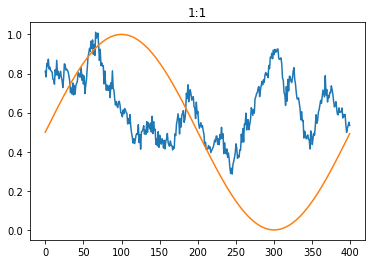

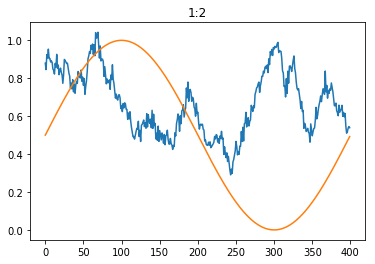

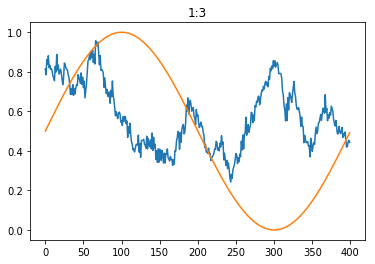

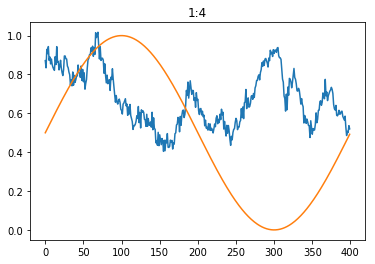

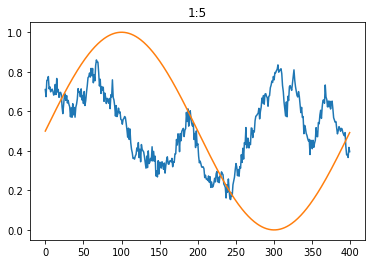

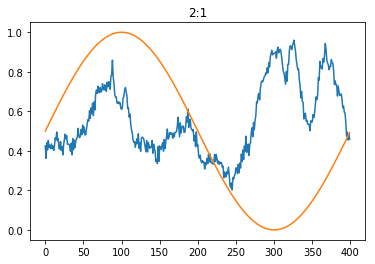

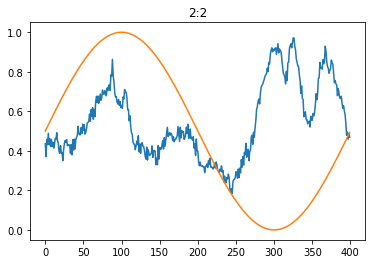

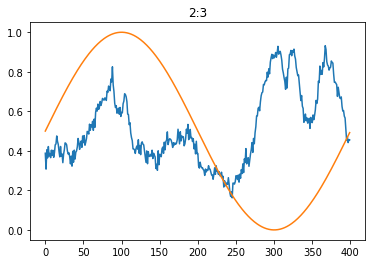

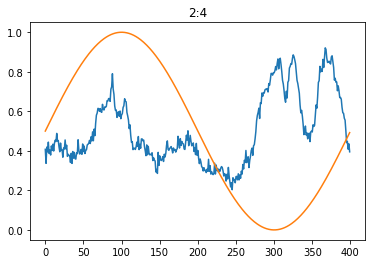

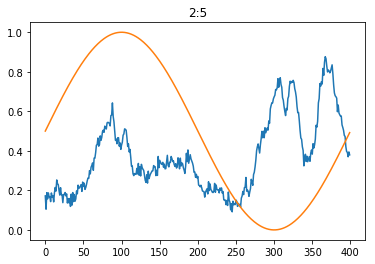

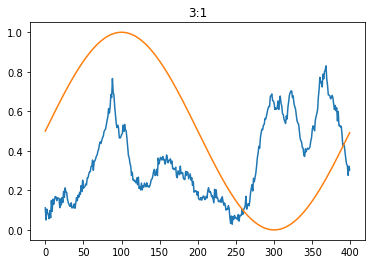

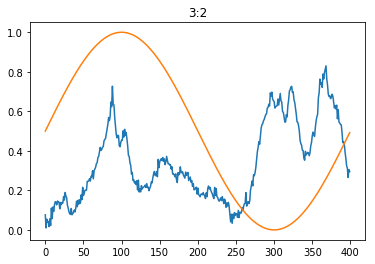

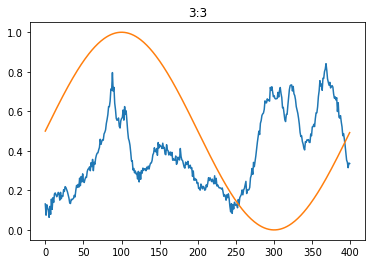

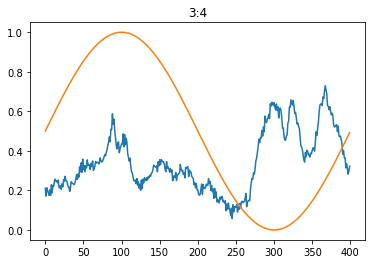

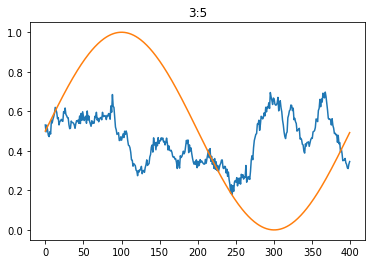

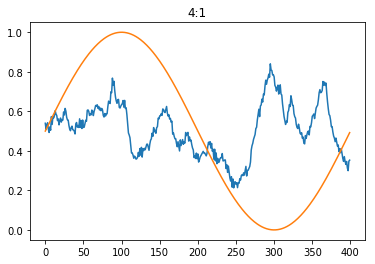

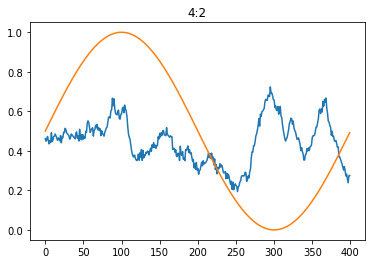

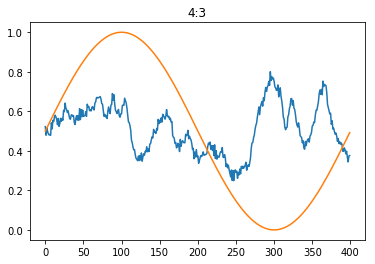

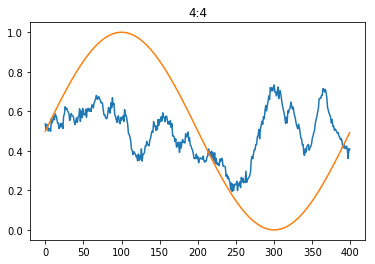

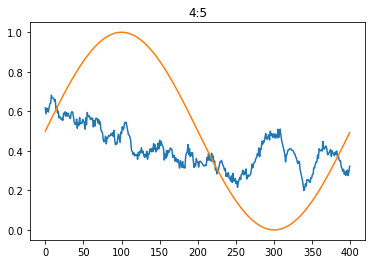

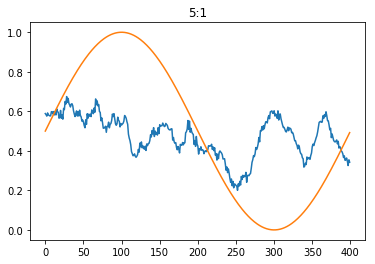

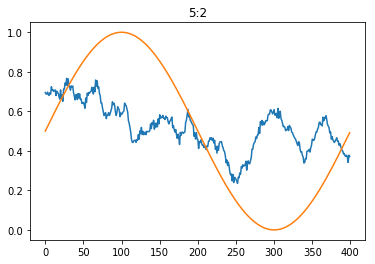

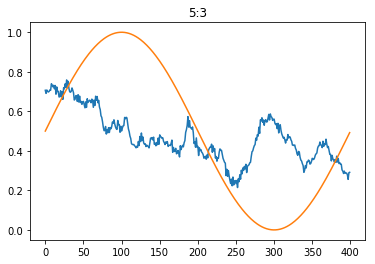

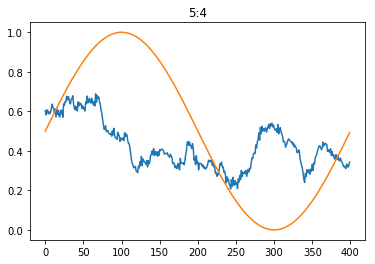

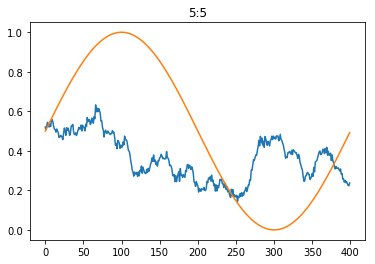

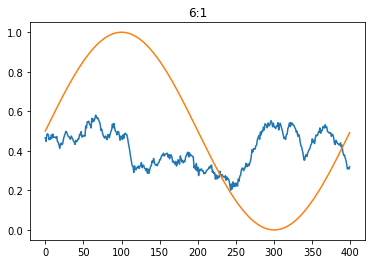

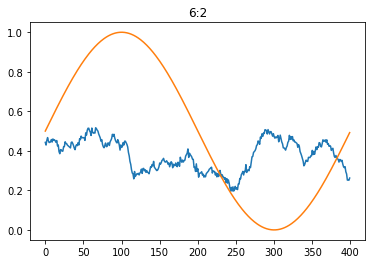

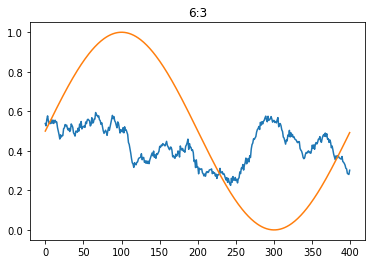

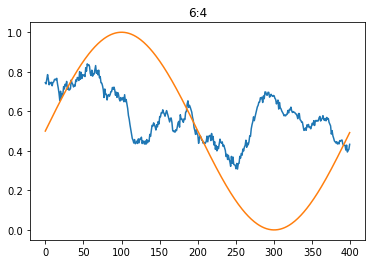

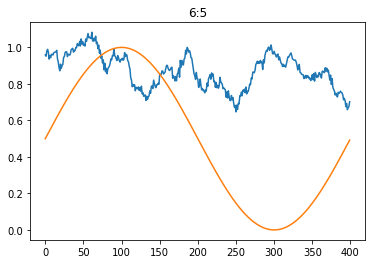

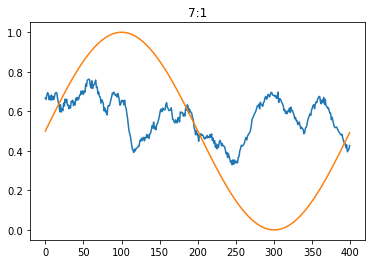

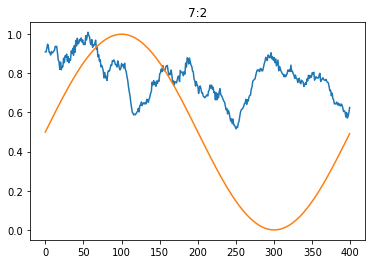

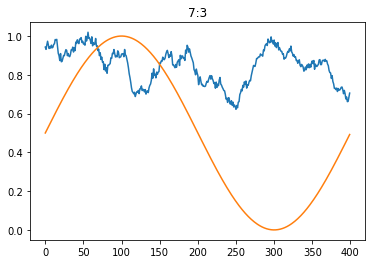

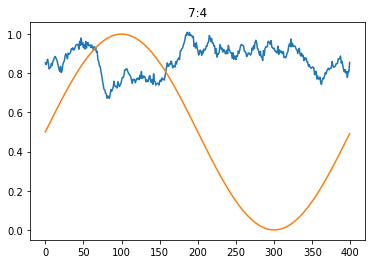

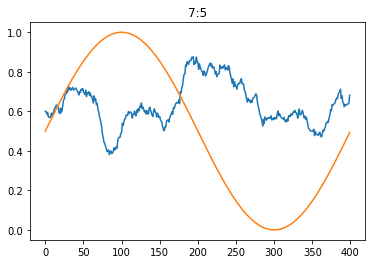

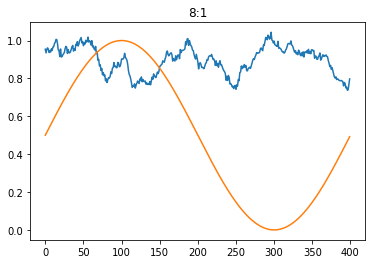

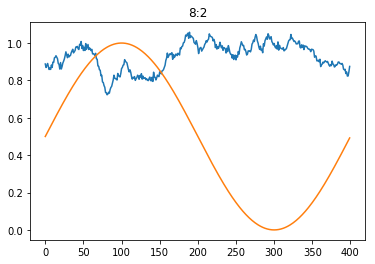

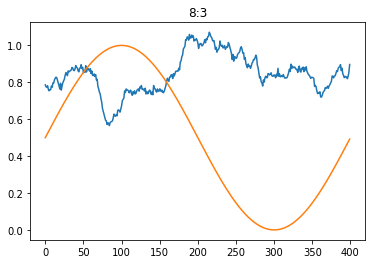

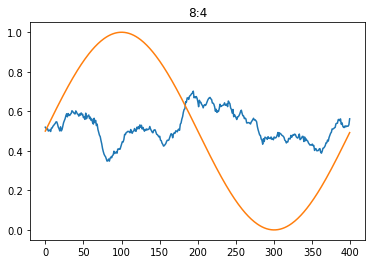

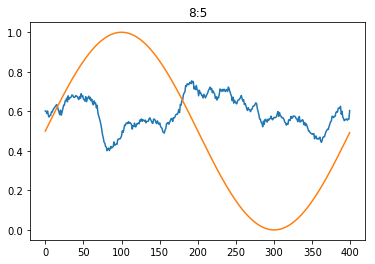

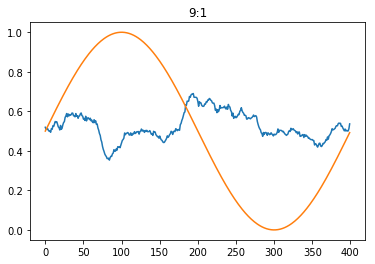

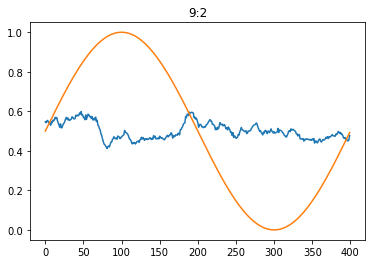

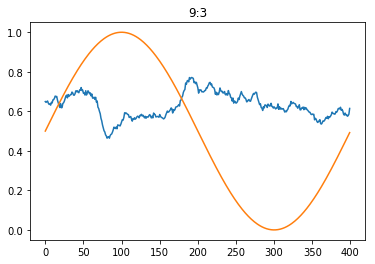

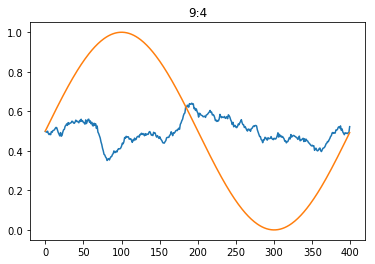

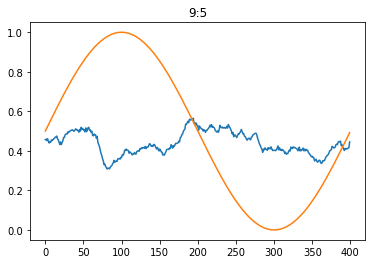

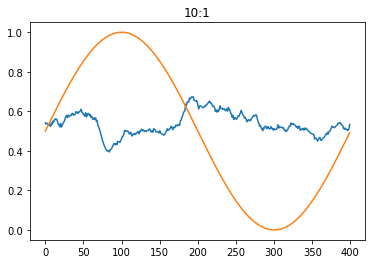

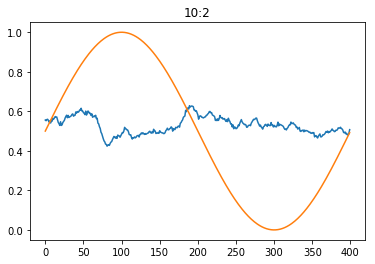

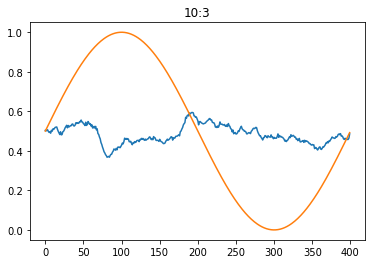

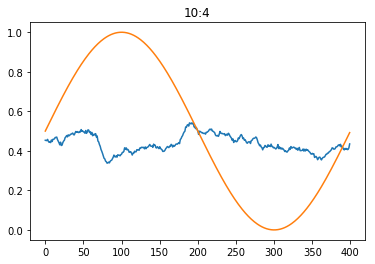

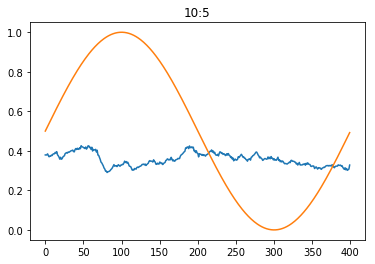

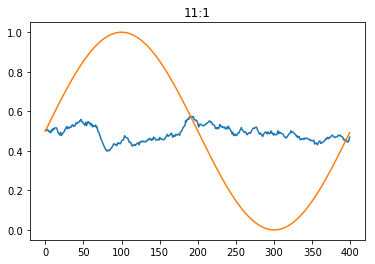

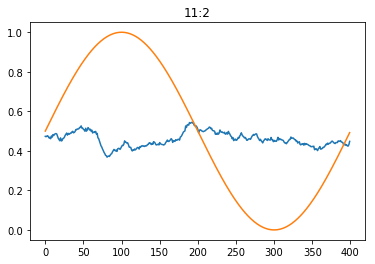

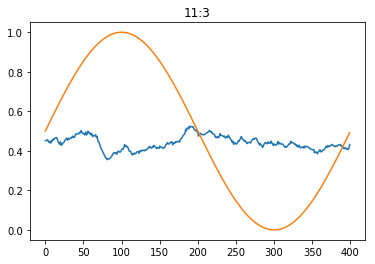

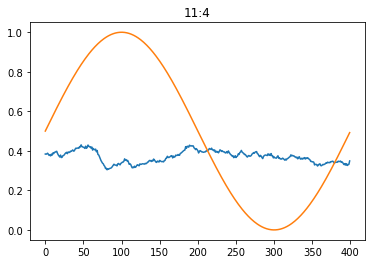

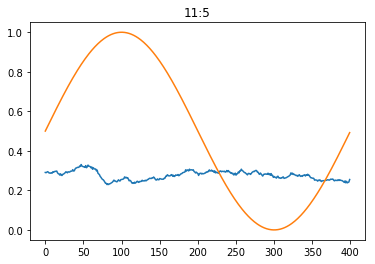

In [44]:
for i in range(11):
    for j in range(5):
        plt.plot(yes[i,j])
        plt.plot(targetFunction)
        plt.title(str(i+1)+":"+str(j+1))
        p = plt.show()